# DL Modeling
- Ignoring data before 2006.
- Using only type=5 examples.
- No feature selection.
- Param tuning.
- Added back removed features ['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4'].
- Removed soil_data features.
- Shift features for 6 months before.
- Use fastai cathegorical feature functionalities.

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear

sns.set(style="whitegrid")

In [ ]:
from fastai.structured import *
from fastai.column_data import *

## Train and test datasets

Basic data containing palm tree information

In [ ]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [ ]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

In [ ]:
df_all_ftrs.head()

In [ ]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

In [ ]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs + ['production']]
df_all_ftrs.head(2)

In [ ]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

In [ ]:
# Get train data only.
df_all_ftrs = df_all_ftrs[~df_all_ftrs.production.isna()]

In [ ]:
val_year = 2010

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

In [ ]:
df, y, nas, mapper = proc_df(df_all_ftrs, y_fld='production', do_scale=True)
df.head(2)

In [ ]:
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

In [ ]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16) # batch size

In [ ]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": 0.00, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [100, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

In [1]:
m = md.get_learner(**learner_params)

NameError: name 'md' is not defined

In [21]:
def load_model_not_strict(m, p):
    sd = torch.load(p, map_location=lambda storage, loc: storage)
    names = set(m.state_dict().keys())
    for n in list(sd.keys()): # list "detatches" the iterator
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    m.load_state_dict(sd, strict=False)

load_model_not_strict(m.model, m.get_model_path('test'))

In [18]:
m.freeze_to(-1)

 73%|███████▎  | 175/241 [00:01<00:00, 166.23it/s, loss=3.09]


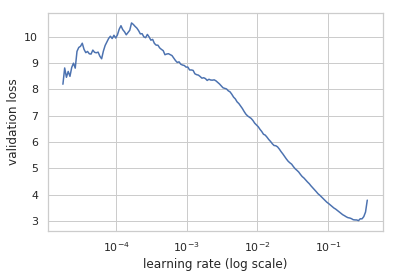

In [19]:
m.lr_find()
m.sched.plot()

In [22]:
lr = 1e-3
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error         
    0      1.93272    0.319933   0.449537  
    1      1.285497   0.268722   0.411398                    
    2      0.521284   0.175805   0.335578                     
    3      0.356822   0.142494   0.303298                     
    4      0.211865   0.092935   0.241882                     
    5      0.181829   0.085164   0.231218                     
    6      0.107697   0.060041   0.192973                     
    7      0.084847   0.055395   0.184673                      
    8      0.058181   0.041755   0.157078                      
    9      0.047102   0.039632   0.152107                      
    10     0.035696   0.033489   0.137069                      
    11     0.035374   0.032067   0.133875                      
    12     0.026399   0.028661   0.122225                      
    13     0.023655   0.028153   0.12062                       
    14     0.020934   0.025714   0.112589                      
    1

[array([0.01914]), 0.09274386283662908]

In [23]:
lr = 1e-3
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.012627   0.018727   0.090602  
    1      0.01077    0.019088   0.091255                      
    2      0.011164   0.018364   0.090774                      
    3      0.012123   0.018252   0.089563                       
    4      0.010472   0.019622   0.092835                      
    5      0.010666   0.018232   0.090196                       
    6      0.010959   0.019455   0.092441                       
    7      0.010249   0.01829    0.089734                       
    8      0.008763   0.018743   0.089778                       
    9      0.008302   0.018507   0.089776                       
    10     0.010419   0.018922   0.089904                       
    11     0.00912    0.019567   0.092727                       
    12     0.008328   0.0216     0.096883                       
    13     0.008607   0.019532   0.093227                       
    14     0.00929    0.019912   0.094266         

[array([0.02121]), 0.09790715271178646]

In [24]:
lr = 1e-3
m.unfreeze()
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error            
    0      0.006605   0.020258   0.094932  
    1      0.006542   0.020444   0.095186                       
    2      0.00743    0.020788   0.097337                       
    3      0.006407   0.021257   0.097852                       
    4      0.007936   0.021415   0.097857                       
    5      0.006866   0.021884   0.098371                       
    6      0.006866   0.021494   0.098585                       
    7      0.006071   0.021486   0.098603                       
    8      0.007069   0.02239    0.1                            
    9      0.005963   0.021289   0.098065                       
    10     0.006303   0.020949   0.096398                       
    11     0.006265   0.021396   0.097433                       
    12     0.007246   0.021724   0.098375                       
    13     0.004999   0.021551   0.098099                       
    14     0.005961   0.022007   0.098691     

[array([0.02243]), 0.09986286789780481]